In [250]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
%matplotlib inline

In [172]:
SEED = 123

In [227]:
def setFontsize(fontSize, ax=ax):
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(fontSize)
    return ax

def estimatorWrapper(Estimator, X_train, y_train, **kwargs):
    est = Estimator(**kwargs)
    est.fit(X_train, y_train)
    return est

In [143]:
train = pd.read_csv("./data/all/train.csv")

In [144]:
train.head()

,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,39353,85475,117961,118300,123472,117905,117906,290919,117908
1,1,17183,1540,117961,118343,123125,118536,118536,308574,118539
2,1,36724,14457,118219,118220,117884,117879,267952,19721,117880
3,1,36135,5396,117961,118343,119993,118321,240983,290919,118322
4,1,42680,5905,117929,117930,119569,119323,123932,19793,119325


In [145]:
train.shape

(32769, 10)

In [146]:
len(train) == len(train.drop_duplicates())

True

In [147]:
train.isnull().sum()

ACTION              0
RESOURCE            0
MGR_ID              0
ROLE_ROLLUP_1       0
ROLE_ROLLUP_2       0
ROLE_DEPTNAME       0
ROLE_TITLE          0
ROLE_FAMILY_DESC    0
ROLE_FAMILY         0
ROLE_CODE           0
dtype: int64

Binary classificaiton problem - what is the distribution of the target variable?

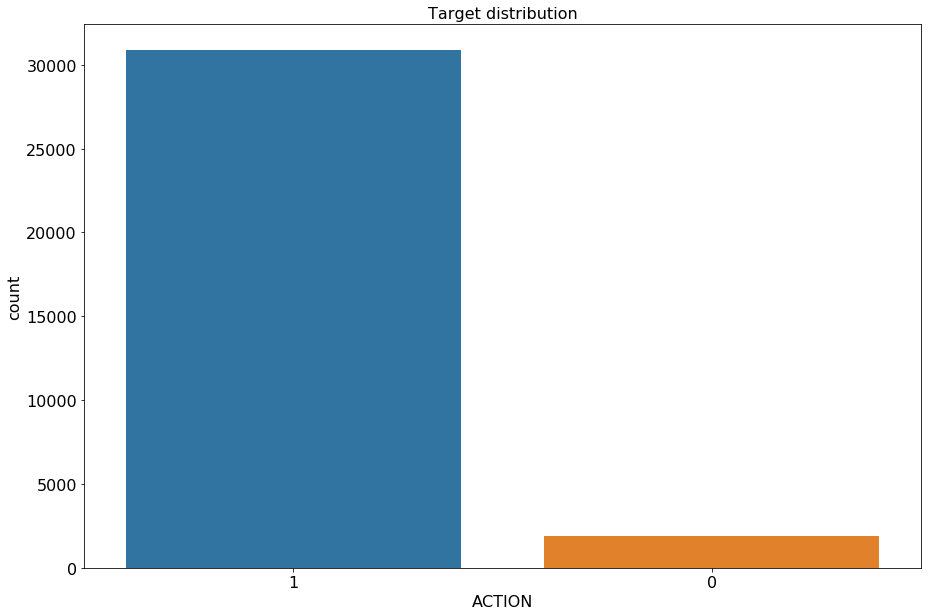

In [148]:
plt.figure(figsize=(15,10))
ax = sns.countplot(train["ACTION"],order=[1,0])
ax.set(title="Target distribution")
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(16)
plt.show()

Massive class imbalance - most resources seem to be approved! Might need to consider under/ over sampling....

In [149]:
train.apply(pd.Series.nunique, axis=0)

ACTION                 2
RESOURCE            7518
MGR_ID              4243
ROLE_ROLLUP_1        128
ROLE_ROLLUP_2        177
ROLE_DEPTNAME        449
ROLE_TITLE           343
ROLE_FAMILY_DESC    2358
ROLE_FAMILY           67
ROLE_CODE            343
dtype: int64

Resources can apply multiple times it seems as well

In [150]:
nEmployees = 20

In [151]:
df = train.groupby(["RESOURCE"]).size().sort_values(ascending=False).rename("accessCount").head(nEmployees)
#df["RESOURCE"] = df["RESOURCE"].astype(str)
plt.figure(figsize=(15,10))
ax = sns.barplot(x="RESOURCE", y="accessCount",data=df)
ax.set(title="Access count for top "+str(nEmployees)+ " employees")
setFontsize(16)
plt.show()

ValueError: Could not interpret input 'RESOURCE'

<Figure size 1080x720 with 0 Axes>

What about the number of employees that fall under a manager?

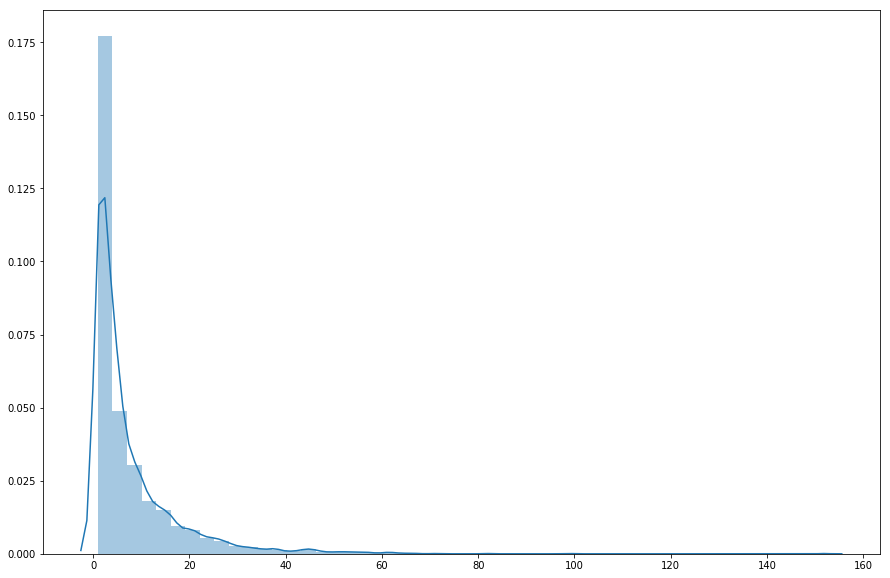

In [152]:
plt.figure(figsize=(15,10))
ax = sns.distplot(train.groupby(["MGR_ID"]).size())
setFontsize(15)
plt.show()

Very skewed distribution. Most managers have <10 employees reporting into them and maximum being ~ 150. The cavaet here though is that we are assuming each record refers to a unique employee, however can an employee make additional requests if they are initally denied? As there is no UUID for employee let's assume that there is no repetition of employees in the dataset...

Does the number of employees reporting into a manager influence the action outcome? If a manager has a large number of employees reporting into s/he then they could potentially have a larger staff turnover and making more frequent requests

In [153]:
tmp = train.copy()
managerRank = pd.qcut(train.groupby(["MGR_ID"]).size().rank(method='first'), 10, labels=range(0,10)).rename("employeeCountRank").reset_index()
tmp = pd.merge(tmp, managerRank, on=["MGR_ID"])
tmp = tmp.groupby(["employeeCountRank","ACTION"]).size()
tmp = tmp.groupby(level=0).apply(lambda x: 100 * x / float(x.sum())).rename("prop").reset_index()

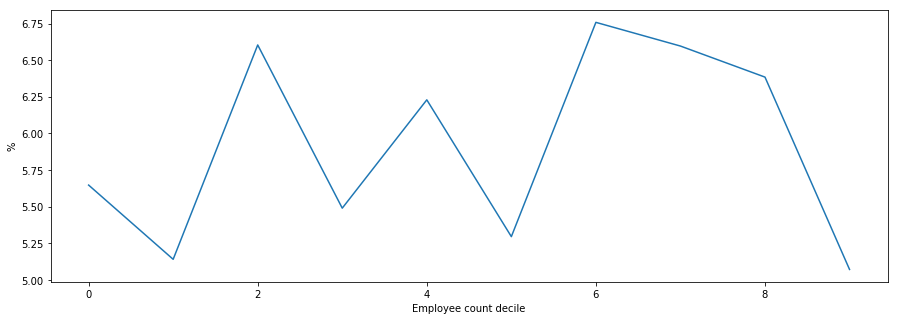

In [154]:
plt.figure(figsize=(15,5))
ax = sns.lineplot(x="employeeCountRank", y="prop",data=tmp.loc[tmp["ACTION"]==0])
ax.set(title="",xlabel="Employee count decile", ylabel="%")
ax=setFontsize(10)
plt.show()

Nothing really to see here - relatively consistent with the overall rejection rate of X%

How big are departments?

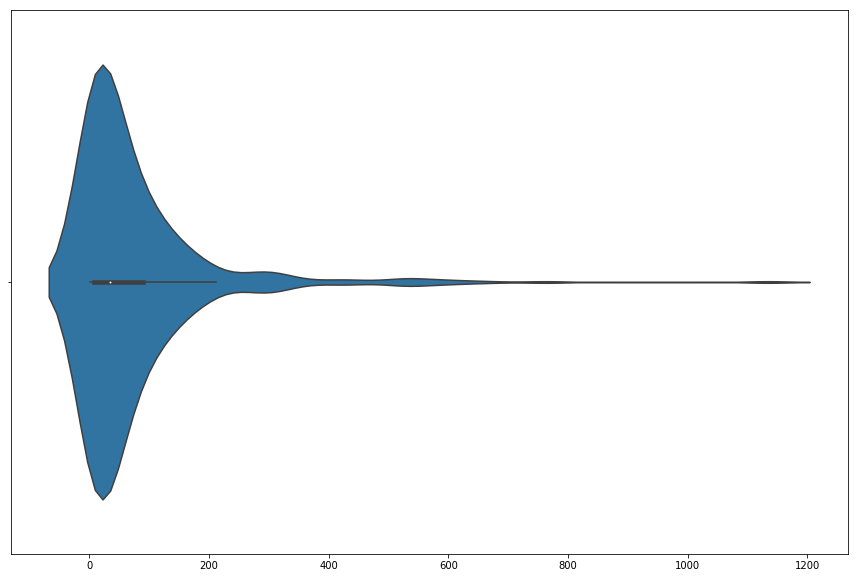

In [155]:
plt.figure(figsize=(15,10))
ax = sns.violinplot(train.groupby(["ROLE_DEPTNAME"]).size())
setFontsize(15)
plt.show()

As ROLE_TITLE and ROLE_CODE are equivalent let's only conisder ROLE_TITLE

In [156]:
train["ROLE_TITLE"].nunique()==len(train[["ROLE_TITLE","ROLE_CODE"]].drop_duplicates())

True

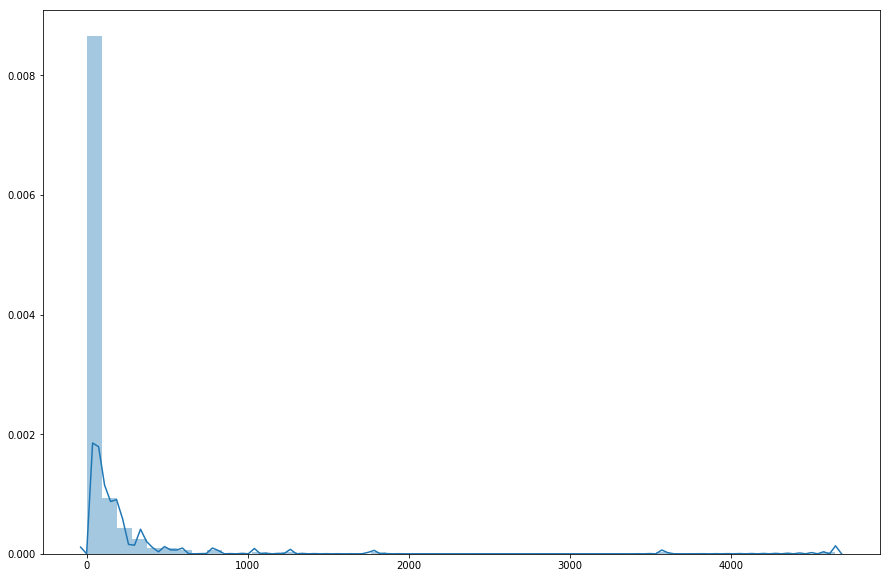

In [157]:
plt.figure(figsize=(15,10))
ax = sns.distplot(train.groupby(["ROLE_TITLE"]).size())
setFontsize(15)
plt.show()

In [158]:
train.groupby(["ROLE_TITLE"]).size().describe()

count     343.000000
mean       95.536443
std       352.768430
min         1.000000
25%         5.000000
50%        17.000000
75%        60.000000
max      4649.000000
dtype: float64

Straight away we see that ROLE_TITLE is quiet more unique than you would expect.  The ROLE_TITLE field may be a concatanation of multiple fields encapsulattaing not just employees role but also department, for example "Coordinater, HR onboarding, EMEA"

In [159]:
train.groupby(["ROLE_TITLE"]).size().rename("employeeCount").sort_values(ascending=False).head(10).reset_index()

,ROLE_TITLE,employeeCount
0,118321,4649
1,117905,3583
2,118784,1772
3,117879,1256
4,118568,1043
5,117885,806
6,118054,774
7,118685,597
8,118777,566
9,118451,521


Let's peak at some of the most common roles

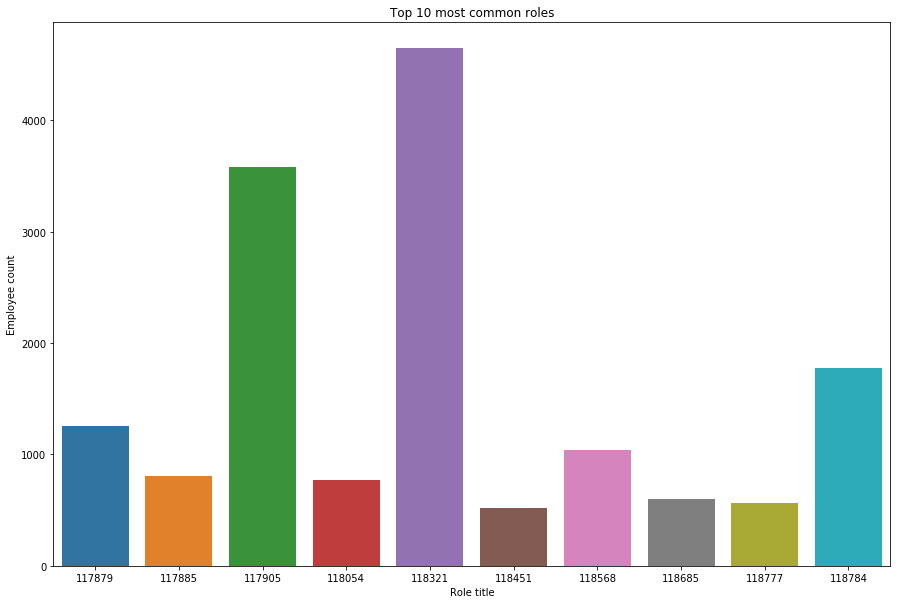

In [160]:
#df["RESOURCE"] = df["RESOURCE"].astype(str)
plt.figure(figsize=(15,10))
ax = sns.barplot(x="ROLE_TITLE", y=0,data=train.groupby(["ROLE_TITLE"]).size().sort_values(ascending=False).reset_index().head(10))
ax.set(title="Top 10 most common roles", xlabel="Role title", ylabel="Employee count")
setFontsize(16)
plt.show()

Looking at top few role titles already we can see a massive skew. How about over all of possible role titles how does this cumulativially look?

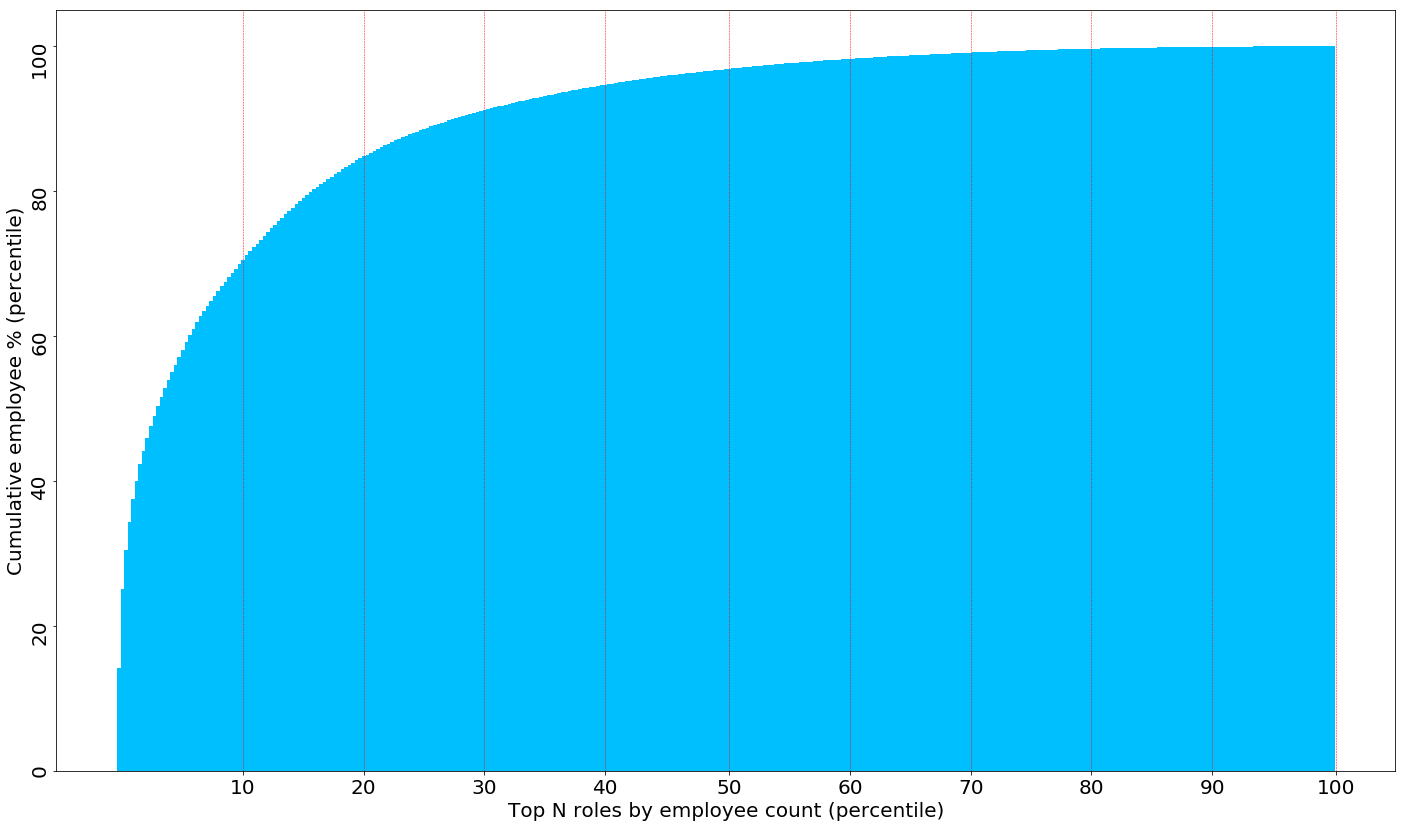

In [161]:
df = train.groupby(["ROLE_TITLE"]).size().sort_values(ascending=False).rename("employeeCount").reset_index()
df["countProp"] = 100*df["employeeCount"]/np.sum(df["employeeCount"])
df["cumulativeProp"] = np.cumsum(df["countProp"])
df["rank"] = df.index+1
df["rankPercentile"] = pd.qcut(df["rank"],q=10,labels=list(range(1,11)))
topNRoles = pd.concat([df.loc[df["rankPercentile"]<=x].tail(1) for x in range(1,11)])
alphab = df["rankPercentile"]
frequencies = df["cumulativeProp"]
pos = np.arange(len(alphab))
width = 1.0     # gives histogram aspect to the bar diagram
plt.figure(figsize=(24,14))
ax = plt.axes()
#posX = np.arange(0,len(alphab))
posX = topNRoles["rank"]
ax.set_xticks(posX)
ax.set_xticklabels(topNRoles["rankPercentile"].astype(int)*10)
ax.set(ylabel="Cumulative employee % (percentile)")
#for xIter in ax.get_xticklabels(): xIter.set_rotation(90)
for yIter in ax.get_yticklabels(): yIter.set_rotation(270)
plt.bar(pos, frequencies, width, color='deepskyblue')
plt.yticks(rotation='vertical')
for xIter in posX:
    plt.axvline(xIter,color="r",linestyle='--', lw=0.5)
plt.xlabel("Top N roles by employee count (percentile)")
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)
plt.show()

Pareto principle strikes again: just over 80% of the employee population are employed in top 20% most common roles.

How does the rejection rate differ over the commoncy of the role?

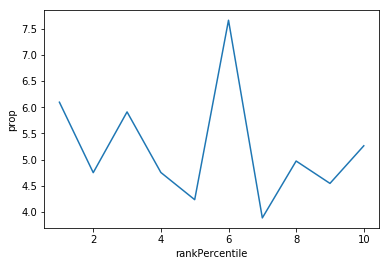

In [162]:
tmp = pd.merge(train, df[["ROLE_TITLE","rankPercentile"]], on=["ROLE_TITLE"])
tmp = tmp.groupby(["rankPercentile", "ACTION"]).size()
tmp = tmp.groupby(level=0).apply(lambda x: 100 * x / float(x.sum())).rename("prop").reset_index()
sns.lineplot(x="rankPercentile", y="prop",data=tmp.loc[tmp["ACTION"]==0])

Assuming a many to one relationship for the rollup we see that ROLE_ROLLUP_1 has the fewer values of the two fields so this is most likley the parent. However looking at the roll up from 2 to 1 we see that there are a few IDs which have multiple parents 

In [163]:
parentCount = train.groupby(["ROLE_ROLLUP_2"])["ROLE_ROLLUP_1"].nunique().sort_values(ascending=False)
parentCount.head(5)

ROLE_ROLLUP_2
119256    9
118164    2
118178    2
286791    1
118217    1
Name: ROLE_ROLLUP_1, dtype: int64

In [164]:
3/len(parentCount)

0.01694915254237288

It is mostly one to one. What is the rejection rate for these rollups?

In [165]:
1-train.loc[train["ROLE_ROLLUP_2"].isin(parentCount.head(3).index)]["ACTION"].sum()/len(train.loc[train["ROLE_ROLLUP_2"].isin(parentCount.head(3).index)])

0.08653846153846156

Interestingley there is an increase of ~50% in the rejection rate is for rollups which multiple parents.

Finally consider the family fields

In [166]:
train.apply(pd.Series.nunique, axis=0)

ACTION                 2
RESOURCE            7518
MGR_ID              4243
ROLE_ROLLUP_1        128
ROLE_ROLLUP_2        177
ROLE_DEPTNAME        449
ROLE_TITLE           343
ROLE_FAMILY_DESC    2358
ROLE_FAMILY           67
ROLE_CODE            343
dtype: int64

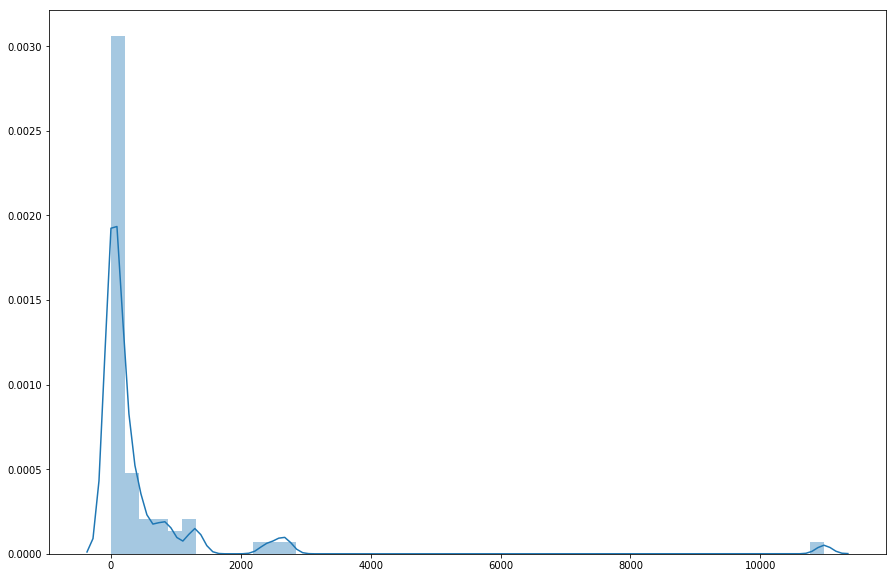

In [167]:
plt.figure(figsize=(15,10))
ax = sns.distplot(train.groupby(["ROLE_FAMILY"]).size().sort_values(ascending=False))
setFontsize(15)
plt.show()

Similarly to ROLE_TITLE there are a lot of values that have very few employees attached to them. Interesting plateau between 11000 mark to ~3000 mark.

Feature engineering

Let's combine the two roll up fields together: these might capture interactions that are not so obvious from above. ROLE_CODE can be removed as it is maps to ROLE_TITLE

In [139]:
train["ROLE_ROLLUP"] = train["ROLE_ROLLUP_2"].astype(str) +"_"+train["ROLE_ROLLUP_1"].astype(str)

In [168]:
train = train.drop(["ROLE_CODE", "ROLE_ROLLUP_2", "ROLE_ROLLUP_1"],axis=1)

In [170]:
Y = train["ACTION"]

In [171]:
X = train.drop(["ACTION"],axis=1)

In [176]:
encoder = OneHotEncoder()

In [177]:
encoder.fit(X)

OneHotEncoder(categorical_features='all', dtype=<class 'numpy.float64'>,
       handle_unknown='error', n_values='auto', sparse=True)

In [178]:
X = encoder.transform(X)

In [179]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=SEED)

Build some classifiers

In [248]:
logReg = estimatorWrapper(LogisticRegression,X_train,y_train)
rf = estimatorWrapper(RandomForestClassifier,X_train,y_train)
svc = estimatorWrapper(SVC,X_train,y_train, probability=True)
gbc = estimatorWrapper(GradientBoostingClassifier,X_train,y_train)

In [251]:
gbc = estimatorWrapper(GradientBoostingClassifier,X_train,y_train)

AUC curve

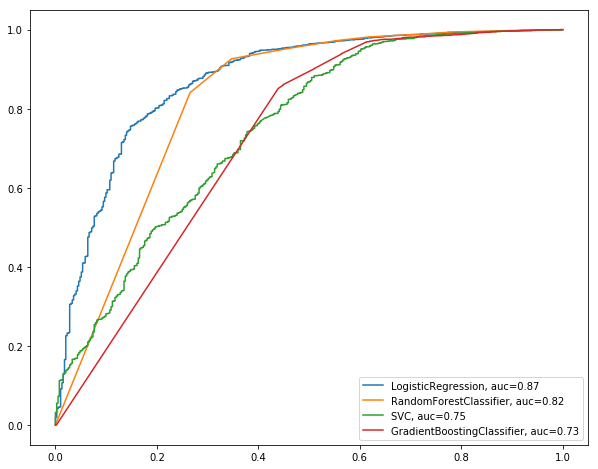

In [252]:
plt.figure(figsize=(10,8))
for estIter in [logReg, rf, svc, gbc]:
    yProb = estIter.predict_proba(X_test)[::,1]
    fpr, tpr, _ = roc_curve(y_test,  yProb)
    auc = roc_auc_score(y_test, yProb)
    plt.plot(fpr,tpr,label=estIter.__class__.__name__+", auc="+str(np.round(auc,2)))
    plt.legend(loc=4)
plt.show()

In [259]:
#TODO: confusion matrices
#cm = pd.DataFrame(
#        confusion_matrix(y_test, logreg.predict(X_test)), index=["Rejected", "Accepted"], columns=["Rejected", "Accepted"], 
#    )
#sns.heatmap(cm)